<a href="https://colab.research.google.com/github/mrezaim/Expanse/blob/main/EXPANSE_two_steps_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implimentation of verifying the effectiveness of two-step training 
method from EXPANSE.

The idea is that similar to human education system, we may improve the accuracy and converegence time by first training the model on perfect data then finetune it on uncertain data.

Some parts of the following codes are imported (with and without adjustments) from "https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/"


---



First we import all the necessary libraries:

---



In [ ]:
from google.colab import files
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import gdown
import cv2
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from numpy import mean
from numpy import std
# to make the results of different run similar:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

Download and import Train and Test data from MNIST:

---



In [ ]:
# Loading the MNIST dataset
#from tensorflow.keras.datasets import mnist
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


Visualize 9 samples of data from MNIST Train dataset:

---



3 8 7 9 9 0 1 1 5 

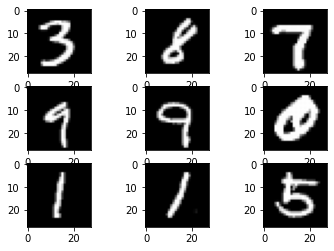

In [ ]:
j=0
for i in range(10000,10009):
  plt.subplot(330 + 1 + j)
  j += 1
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  print (trainy[i], end =" ")
plt.show()

Download the perfect samples pallet. It is a PNG file of 180 perfect samples 
(typed with different fonts).

---



In [ ]:
url = 'https://github.com/mrezaim/Expanse/raw/main/perfect_digits.png'
output = 'perfect_digits.png'
gdown.download(url, output, quiet=False)

Downloading...
From: https://github.com/mrezaim/Expanse/raw/main/perfect_digits.png
To: /content/perfect_digits.png
100%|██████████| 26.6k/26.6k [00:00<00:00, 11.9MB/s]


'perfect_digits.png'

Extracting 360 samples from the perfect samples pallet and creatint train and test dataset by duplicate of samples. 

---



In [ ]:
img_path = 'perfect_digits.png'
img = cv2.imread(img_path, 0)
#train_per_x = np.empty_like(trainX)
train_per_x = np.zeros(shape = ( 360, 28, 28 ), dtype=np.uint8)
train_per_y = np.zeros(shape = ( 360), dtype=np.uint8)
i=0
for v in range(18):
  for h in range(10):
    train_per_x[i] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    train_per_y[i] = h
    train_per_x[i+180] = (img[4+(v*36):(v*36)+32, 4+(h*36):(h*36)+32])
    train_per_y[i+180] = h
    i += 1

print('Perfect train dataset shape:', train_per_x.shape)
print('Perfect train label dataset shape:', train_per_y.shape)


Perfect train dataset shape: (360, 28, 28)
Perfect train label dataset shape: (360,)


Visualize 9 samples of data from perfect train dataset:

---



1 2 3 4 5 6 7 8 9 

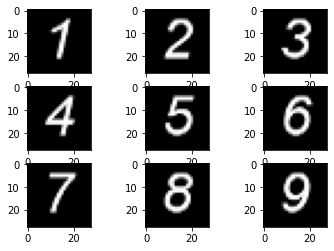

In [ ]:
j=0
for i in range(211,220):
  plt.subplot(330 + 1 + j)
  j += 1
  plt.imshow(train_per_x[i], cmap=plt.get_cmap('gray'))
  print (train_per_y[i], end =" ")
plt.show()

Reshape datasets to prepare for the model

---



In [ ]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

train_per_x = train_per_x.reshape((train_per_x.shape[0], 28, 28, 1))

Convert the label datasets to categorical since there are 10 possible target categories of digits:

---



In [ ]:
# one hot encode target values
trainy = tf.keras.utils.to_categorical(trainy)
testy = tf.keras.utils.to_categorical(testy)

train_per_y = tf.keras.utils.to_categorical(train_per_y)


Convert the datasets of images from 8-bit grayscale pixels values to float values and normalize the values to range of 0 and 1:

---



In [ ]:
# convert from integers to floats
trainX = trainX.astype('float32')
test_X = testX.astype('float32')
# normalize to range 0-1
trainX = trainX / 255.0
testX = testX / 255.0

# convert from integers to floats
train_per_x = train_per_x.astype('float32')
# normalize to range 0-1
train_per_x = train_per_x / 255.0


The function to creat a model. Here we are using a dense relu based model with Adam optimizer and default learning rate of 0.01.

---



In [ ]:
# define model
def define_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(Dense(128, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = Adam(0.01)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

The function to run the model on given dataset and parameters using k-fold cross-validation:

---



In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(model, dataX, dataY, n_folds, n_epochs, n_batch_size):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch_size, validation_data=(testX, testY))
		# evaluate model
		_, acc = model.evaluate(testX, testY)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories, model

Creating the base random intitialized model and save it to reuse for the baseline. We want to use same random weights for comparing different methods fairly:

---



In [ ]:
model = define_model()
model.build((None, 28, 28, 1))
model.save("random_init")

INFO:tensorflow:Assets written to: random_init/assets


Verifying the model layers, number of nodes, and parameters:

---



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


Function for visualizing model training performance: 

---



In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  for i in range(len(histories)):
      # plot loss
      plt.subplot(2, 2, 1)
      plt.title('Cross Entropy Loss')
      plt.plot(histories[i].history['loss'], color='blue', label='train')
      plt.plot(histories[i].history['val_loss'], color='orange', label='test')
      # plot accuracy
      plt.subplot(2, 2, 2)
      plt.title('Classification Accuracy')
      plt.plot(histories[i].history['accuracy'], color='blue', label='train')
      plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

Creating a list to save each run performance on perfect train set, perfect test set, MNIST train set, MNIST test set

---



In [ ]:
results = ([])

Saving the results of randomly initialized model with no training:

---



In [ ]:
desc = "Random initialized with no training"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

['Random initialized with no training', 11.667, 10.393, 11.16]


Training random intialized model on MNIST with different learning rates: 

---



Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 2.0343 - accuracy: 0.4829 - val_loss: 1.0921 - val_accuracy: 0.5442
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 1.1333 - accuracy: 0.5417 - val_loss: 1.1809 - val_accuracy: 0.5188
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 1.1167 - accuracy: 0.5442
> 54.417
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 1.1511 - accuracy: 0.5338 - val_loss: 1.1842 - val_accuracy: 0.5217
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 1.5267 - accuracy: 0.4181 - val_loss: 1.5806 - val_accuracy: 0.3970
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 1.9176 - accuracy: 0.1993
> 19.933
Epoch 1/3
375/375 [==============================] - 3s 7ms/step - loss: 1.9477 - accuracy: 0.1941 - val_loss: 1.9692 - val_accuracy: 0.2053
Epoch 2/3
375/375 [==============================] - 3s 7ms/step - loss: 1.9577

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


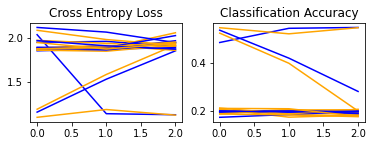

Accuracy: mean=22.507 std=10.687, n=10


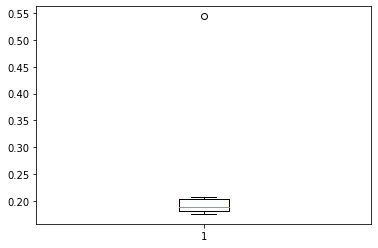

['Random initialized on MNIST with LR=0.1 & epoch=3', 9.444, 18.385, 18.51]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.1)
scores, histories, model = evaluate_model(model, trainX, trainy,10,3,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.1 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.2311 - accuracy: 0.9294 - val_loss: 0.1436 - val_accuracy: 0.9570
Epoch 2/3
375/375 [==============================] - 3s 7ms/step - loss: 0.1171 - accuracy: 0.9645 - val_loss: 0.1214 - val_accuracy: 0.9692
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.1205 - accuracy: 0.9698
> 96.983
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0913 - accuracy: 0.9733 - val_loss: 0.1122 - val_accuracy: 0.9697
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0808 - accuracy: 0.9771 - val_loss: 0.0999 - val_accuracy: 0.9698
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.0803 - accuracy: 0.9778
> 97.783
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0812 - accuracy: 0.9777 - val_loss: 0.0983 - val_accuracy: 0.9730
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0657

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


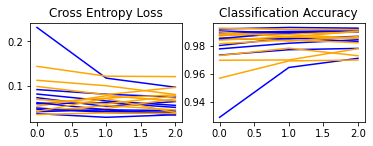

Accuracy: mean=98.303 std=0.699, n=10


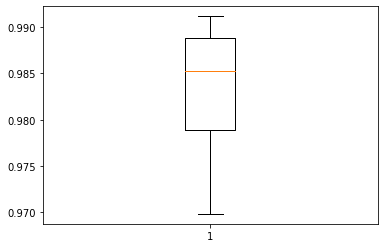

['Random initialized on MNIST with LR=0.01 & epoch=3', 56.111, 99.287, 97.54]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.01)
scores, histories, model = evaluate_model(model, trainX, trainy,10,3,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.01 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.3069 - accuracy: 0.9131 - val_loss: 0.1712 - val_accuracy: 0.9503
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.1142 - accuracy: 0.9651 - val_loss: 0.1215 - val_accuracy: 0.9657
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.1081 - accuracy: 0.9665
> 96.650
Epoch 1/3
375/375 [==============================] - 3s 7ms/step - loss: 0.0614 - accuracy: 0.9814 - val_loss: 0.0573 - val_accuracy: 0.9822
Epoch 2/3
375/375 [==============================] - 3s 7ms/step - loss: 0.0434 - accuracy: 0.9863 - val_loss: 0.0587 - val_accuracy: 0.9815
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.0497 - accuracy: 0.9838
> 98.383
Epoch 1/3
375/375 [==============================] - 3s 7ms/step - loss: 0.0291 - accuracy: 0.9908 - val_loss: 0.0269 - val_accuracy: 0.9925
Epoch 2/3
375/375 [==============================] - 3s 7ms/step - loss: 0.0219

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


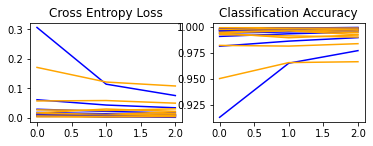

Accuracy: mean=99.088 std=0.912, n=10


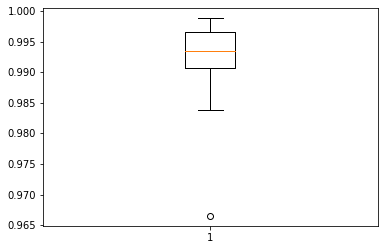

['Random initialized on MNIST with LR=0.001 & epoch=3', 55.556, 99.928, 98.04]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,3,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.2508 - accuracy: 0.9257 - val_loss: 0.1371 - val_accuracy: 0.9580
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0955 - accuracy: 0.9699 - val_loss: 0.1168 - val_accuracy: 0.9668
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.1043 - accuracy: 0.9680
> 96.800
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0527 - accuracy: 0.9835 - val_loss: 0.0470 - val_accuracy: 0.9852
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0390 - accuracy: 0.9873 - val_loss: 0.0582 - val_accuracy: 0.9825
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.0571 - accuracy: 0.9825
> 98.250
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0292 - accuracy: 0.9900 - val_loss: 0.0256 - val_accuracy: 0.9933
Epoch 2/3
375/375 [==============================] - 3s 7ms/step - loss: 0.0221

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


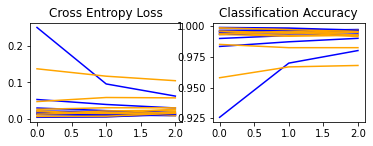

Accuracy: mean=99.033 std=0.838, n=10


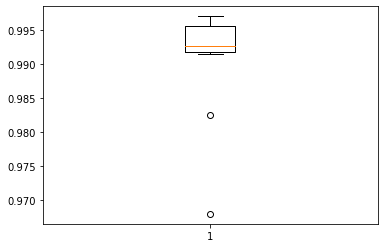

['Random initialized on MNIST with LR=0.002 & epoch=3', 57.222, 99.57, 97.83]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.002)
scores, histories, model = evaluate_model(model, trainX, trainy,10,3,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.002 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.8666 - accuracy: 0.7888 - val_loss: 0.3716 - val_accuracy: 0.9012
Epoch 2/3
375/375 [==============================] - 3s 7ms/step - loss: 0.3093 - accuracy: 0.9141 - val_loss: 0.2808 - val_accuracy: 0.9248
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.2369 - accuracy: 0.9335
> 93.350
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.2099 - accuracy: 0.9412 - val_loss: 0.1845 - val_accuracy: 0.9473
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.1840 - accuracy: 0.9477 - val_loss: 0.1711 - val_accuracy: 0.9505
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.1553 - accuracy: 0.9547
> 95.467
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.1472 - accuracy: 0.9583 - val_loss: 0.1492 - val_accuracy: 0.9593
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.1332

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


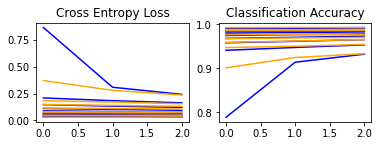

Accuracy: mean=97.325 std=1.726, n=10


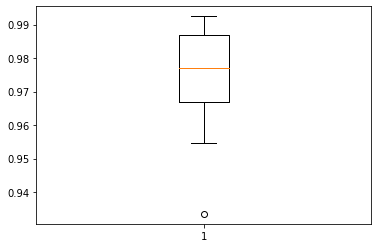

['Random initialized on MNIST with LR=0.0001 & epoch=3', 47.222, 99.38, 97.8]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,3,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on MNIST with LR=0.0001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Training random intialized model on perfect training set with different learning rates:

---



Epoch 1/8
3/3 [==============================] - 1s 98ms/step - loss: 54.0631 - accuracy: 0.0926 - val_loss: 5.7278 - val_accuracy: 0.2222
Epoch 2/8
3/3 [==============================] - 0s 20ms/step - loss: 7.4128 - accuracy: 0.1636 - val_loss: 2.4046 - val_accuracy: 0.1944
Epoch 3/8
3/3 [==============================] - 0s 18ms/step - loss: 2.4790 - accuracy: 0.2377 - val_loss: 2.3133 - val_accuracy: 0.1944
Epoch 4/8
3/3 [==============================] - 0s 21ms/step - loss: 1.9726 - accuracy: 0.2407 - val_loss: 2.0821 - val_accuracy: 0.2778
Epoch 5/8
3/3 [==============================] - 0s 22ms/step - loss: 1.8491 - accuracy: 0.3117 - val_loss: 2.1953 - val_accuracy: 0.2778
Epoch 6/8
3/3 [==============================] - 0s 20ms/step - loss: 1.7631 - accuracy: 0.3148 - val_loss: 2.1394 - val_accuracy: 0.2778
Epoch 7/8
3/3 [==============================] - 0s 30ms/step - loss: 1.6995 - accuracy: 0.3426 - val_loss: 2.1120 - val_accuracy: 0.2222
Epoch 8/8
2/2 [==================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


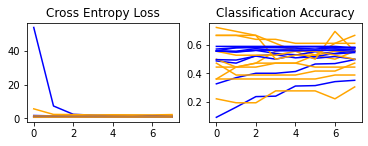

Accuracy: mean=50.556 std=10.153, n=10


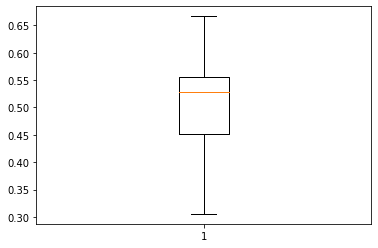

['Random initialized on perfect data with LR=0.1 & epoch=8', 56.667, 21.275, 21.85]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.1)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,8,144)

model.save("trained_perfect_0.1")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.1 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/8
3/3 [==============================] - 1s 95ms/step - loss: 11.2086 - accuracy: 0.0802 - val_loss: 2.8365 - val_accuracy: 0.2500
Epoch 2/8
3/3 [==============================] - 0s 19ms/step - loss: 3.3869 - accuracy: 0.2130 - val_loss: 1.9744 - val_accuracy: 0.2778
Epoch 3/8
3/3 [==============================] - 0s 20ms/step - loss: 1.7287 - accuracy: 0.4352 - val_loss: 1.5720 - val_accuracy: 0.4722
Epoch 4/8
3/3 [==============================] - 0s 23ms/step - loss: 1.2140 - accuracy: 0.5679 - val_loss: 1.5384 - val_accuracy: 0.5556
Epoch 5/8
3/3 [==============================] - 0s 19ms/step - loss: 0.8384 - accuracy: 0.7346 - val_loss: 1.1882 - val_accuracy: 0.5833
Epoch 6/8
3/3 [==============================] - 0s 20ms/step - loss: 0.5474 - accuracy: 0.8364 - val_loss: 0.7631 - val_accuracy: 0.7500
Epoch 7/8
3/3 [==============================] - 0s 22ms/step - loss: 0.3574 - accuracy: 0.8642 - val_loss: 0.7855 - val_accuracy: 0.8056
Epoch 8/8
2/2 [==================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


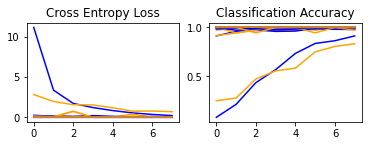

Accuracy: mean=98.056 std=4.977, n=10


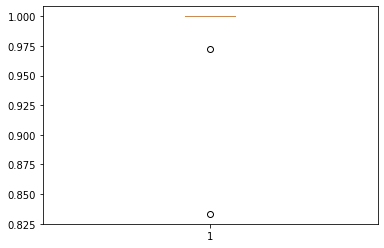

['Random initialized on perfect data with LR=0.05 & epoch=8', 100.0, 33.698, 34.86]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.05)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,8,144)

model.save("trained_perfect_0.05")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.05 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/8
3/3 [==============================] - 1s 100ms/step - loss: 3.2401 - accuracy: 0.1173 - val_loss: 2.1602 - val_accuracy: 0.1944
Epoch 2/8
3/3 [==============================] - 0s 19ms/step - loss: 2.1229 - accuracy: 0.2963 - val_loss: 1.8881 - val_accuracy: 0.2778
Epoch 3/8
3/3 [==============================] - 0s 28ms/step - loss: 1.5346 - accuracy: 0.4815 - val_loss: 1.5051 - val_accuracy: 0.5278
Epoch 4/8
3/3 [==============================] - 0s 20ms/step - loss: 0.9390 - accuracy: 0.6728 - val_loss: 1.2110 - val_accuracy: 0.6389
Epoch 5/8
3/3 [==============================] - 0s 22ms/step - loss: 0.4646 - accuracy: 0.8519 - val_loss: 1.2127 - val_accuracy: 0.6944
Epoch 6/8
3/3 [==============================] - 0s 19ms/step - loss: 0.2873 - accuracy: 0.9105 - val_loss: 0.8801 - val_accuracy: 0.7778
Epoch 7/8
3/3 [==============================] - 0s 22ms/step - loss: 0.1452 - accuracy: 0.9475 - val_loss: 0.6873 - val_accuracy: 0.8333
Epoch 8/8
2/2 [==================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


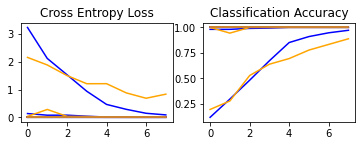

Accuracy: mean=98.889 std=3.333, n=10


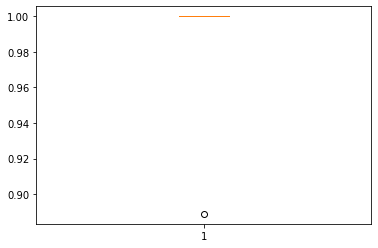

['Random initialized on perfect data with LR=0.02 & epoch=8', 100.0, 37.223, 38.29]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.02)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,8,144)

model.save("trained_perfect_0.02")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.02 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/8
3/3 [==============================] - 1s 104ms/step - loss: 2.4379 - accuracy: 0.1265 - val_loss: 2.0471 - val_accuracy: 0.1667
Epoch 2/8
3/3 [==============================] - 0s 20ms/step - loss: 1.7740 - accuracy: 0.3951 - val_loss: 1.6402 - val_accuracy: 0.4444
Epoch 3/8
3/3 [==============================] - 0s 19ms/step - loss: 1.0857 - accuracy: 0.7037 - val_loss: 1.3384 - val_accuracy: 0.6111
Epoch 4/8
3/3 [==============================] - 0s 19ms/step - loss: 0.5817 - accuracy: 0.8395 - val_loss: 1.1537 - val_accuracy: 0.6667
Epoch 5/8
3/3 [==============================] - 0s 19ms/step - loss: 0.3220 - accuracy: 0.8858 - val_loss: 1.0466 - val_accuracy: 0.7778
Epoch 6/8
3/3 [==============================] - 0s 22ms/step - loss: 0.1920 - accuracy: 0.9414 - val_loss: 0.8597 - val_accuracy: 0.8056
Epoch 7/8
3/3 [==============================] - 0s 21ms/step - loss: 0.0968 - accuracy: 0.9815 - val_loss: 0.8385 - val_accuracy: 0.9167
Epoch 8/8
2/2 [==================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


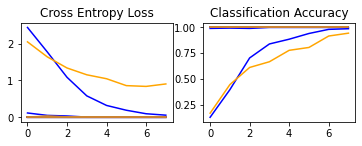

Accuracy: mean=99.444 std=1.667, n=10


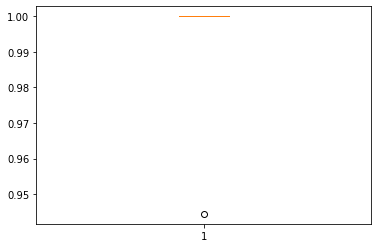

['Random initialized on perfect data with LR=0.01 & epoch=8', 100.0, 39.537, 41.24]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.01)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,8,144)

model.save("trained_perfect_0.01")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.01 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/8
3/3 [==============================] - 1s 99ms/step - loss: 2.2852 - accuracy: 0.1265 - val_loss: 2.0427 - val_accuracy: 0.2500
Epoch 2/8
3/3 [==============================] - 0s 23ms/step - loss: 1.6588 - accuracy: 0.5833 - val_loss: 1.6109 - val_accuracy: 0.4444
Epoch 3/8
3/3 [==============================] - 0s 19ms/step - loss: 1.0335 - accuracy: 0.7562 - val_loss: 1.3511 - val_accuracy: 0.5833
Epoch 4/8
3/3 [==============================] - 0s 18ms/step - loss: 0.6451 - accuracy: 0.8333 - val_loss: 1.1700 - val_accuracy: 0.6111
Epoch 5/8
3/3 [==============================] - 0s 19ms/step - loss: 0.3967 - accuracy: 0.8735 - val_loss: 1.0773 - val_accuracy: 0.6944
Epoch 6/8
3/3 [==============================] - 0s 21ms/step - loss: 0.2742 - accuracy: 0.9321 - val_loss: 0.8134 - val_accuracy: 0.8056
Epoch 7/8
3/3 [==============================] - 0s 21ms/step - loss: 0.1571 - accuracy: 0.9691 - val_loss: 0.6938 - val_accuracy: 0.8611
Epoch 8/8
2/2 [===================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


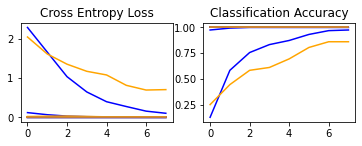

Accuracy: mean=98.611 std=4.167, n=10


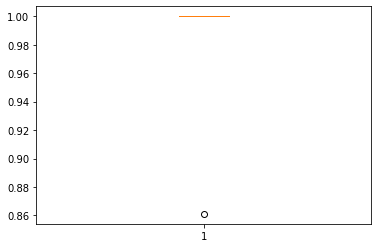

['Random initialized on perfect data with LR=0.005 & epoch=8', 100.0, 37.337, 38.7]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.005)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,8,144)

model.save("trained_perfect_0.005")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.005 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/8
3/3 [==============================] - 1s 103ms/step - loss: 2.2853 - accuracy: 0.1605 - val_loss: 2.2019 - val_accuracy: 0.1667
Epoch 2/8
3/3 [==============================] - 0s 20ms/step - loss: 2.0735 - accuracy: 0.3704 - val_loss: 2.1040 - val_accuracy: 0.1944
Epoch 3/8
3/3 [==============================] - 0s 19ms/step - loss: 1.8956 - accuracy: 0.5864 - val_loss: 1.9897 - val_accuracy: 0.3889
Epoch 4/8
3/3 [==============================] - 0s 21ms/step - loss: 1.7136 - accuracy: 0.7037 - val_loss: 1.8805 - val_accuracy: 0.5000
Epoch 5/8
3/3 [==============================] - 0s 20ms/step - loss: 1.5250 - accuracy: 0.7438 - val_loss: 1.7754 - val_accuracy: 0.4444
Epoch 6/8
3/3 [==============================] - 0s 22ms/step - loss: 1.3320 - accuracy: 0.7778 - val_loss: 1.6542 - val_accuracy: 0.4722
Epoch 7/8
3/3 [==============================] - 0s 22ms/step - loss: 1.1404 - accuracy: 0.8272 - val_loss: 1.5237 - val_accuracy: 0.5278
Epoch 8/8
2/2 [==================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


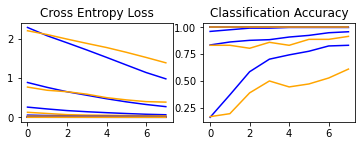

Accuracy: mean=95.278 std=11.657, n=10


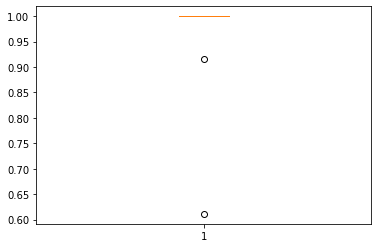

['Random initialized on perfect data with LR=0.001 & epoch=8', 100.0, 37.162, 38.41]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, train_per_x, train_per_y,10,8,144)

model.save("trained_perfect_0.001")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on perfect data with LR=0.001 & epoch=8"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Finetune a trained model with perfect data on MNIST

---



Epoch 1/3
375/375 [==============================] - 4s 9ms/step - loss: 4.8677 - accuracy: 0.5457 - val_loss: 1.7002 - val_accuracy: 0.6832
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 1.0269 - accuracy: 0.7606 - val_loss: 0.6845 - val_accuracy: 0.8118
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.4552 - accuracy: 0.8607
> 86.067
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.3928 - accuracy: 0.8837 - val_loss: 0.3273 - val_accuracy: 0.9037
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.3175 - accuracy: 0.9054 - val_loss: 0.2739 - val_accuracy: 0.9190
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.2382 - accuracy: 0.9285
> 92.850
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.2296 - accuracy: 0.9313 - val_loss: 0.2310 - val_accuracy: 0.9328
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.2029

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


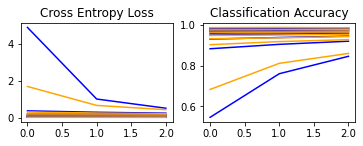

Accuracy: mean=95.480 std=3.582, n=10


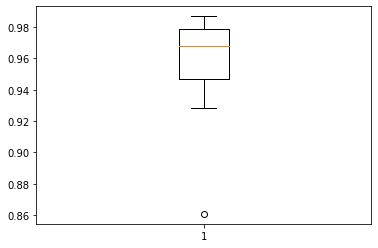

['Finetune on MNIST with LR=0.0001 & epoch=3', 83.889, 98.813, 97.49]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,3,144)

model.save("finetuned_1")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on MNIST with LR=0.0001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
375/375 [==============================] - 4s 9ms/step - loss: 0.5099 - accuracy: 0.8981 - val_loss: 0.1634 - val_accuracy: 0.9523
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.1139 - accuracy: 0.9644 - val_loss: 0.1203 - val_accuracy: 0.9647
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.1043 - accuracy: 0.9675
> 96.750
Epoch 1/3
375/375 [==============================] - 4s 10ms/step - loss: 0.0600 - accuracy: 0.9816 - val_loss: 0.0578 - val_accuracy: 0.9822
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0423 - accuracy: 0.9868 - val_loss: 0.0648 - val_accuracy: 0.9807
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.9800
> 98.000
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0302 - accuracy: 0.9904 - val_loss: 0.0265 - val_accuracy: 0.9922
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.024

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


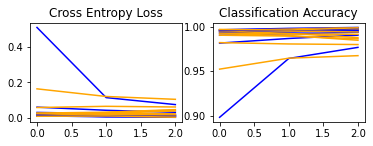

Accuracy: mean=98.868 std=0.925, n=10


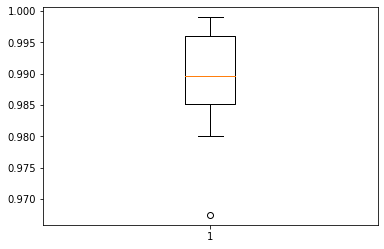

['Finetune on MNIST with LR=0.002 & epoch=3', 68.333, 99.933, 97.97]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.002)
scores, histories, model = evaluate_model(model, trainX, trainy,10,3,144)

model.save("finetuned_2")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on MNIST with LR=0.002 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.8254 - accuracy: 0.8529 - val_loss: 0.2069 - val_accuracy: 0.9373
Epoch 2/3
375/375 [==============================] - 3s 7ms/step - loss: 0.1553 - accuracy: 0.9530 - val_loss: 0.1446 - val_accuracy: 0.9587
Epoch 3/3
188/188 [==============================] - 0s 3ms/step - loss: 0.1240 - accuracy: 0.9637
> 96.367
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0815 - accuracy: 0.9754 - val_loss: 0.0785 - val_accuracy: 0.9752
Epoch 2/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0610 - accuracy: 0.9816 - val_loss: 0.0771 - val_accuracy: 0.9760
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9790
> 97.900
Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.0419 - accuracy: 0.9875 - val_loss: 0.0341 - val_accuracy: 0.9920
Epoch 2/3
375/375 [==============================] - 3s 7ms/step - loss: 0.0316

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


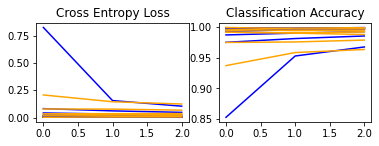

Accuracy: mean=99.043 std=1.060, n=10


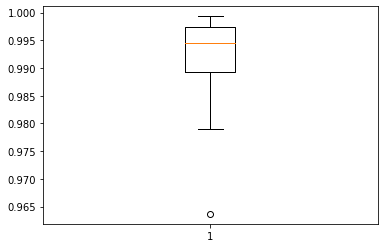

['Finetune on MNIST with LR=0.001 & epoch=3', 70.0, 99.897, 97.89]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, trainX, trainy,10,3,144)

model.save("finetuned_2")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on MNIST with LR=0.001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
375/375 [==============================] - 3s 8ms/step - loss: 0.3317 - accuracy: 0.9242 - val_loss: 0.1406 - val_accuracy: 0.9555
Epoch 2/3
375/375 [==============================] - 3s 7ms/step - loss: 0.1011 - accuracy: 0.9677 - val_loss: 0.1237 - val_accuracy: 0.9660
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.1205 - accuracy: 0.9640
> 96.400
Epoch 1/3
375/375 [==============================] - 3s 9ms/step - loss: 0.0676 - accuracy: 0.9784 - val_loss: 0.0523 - val_accuracy: 0.9852
Epoch 2/3
375/375 [==============================] - 4s 10ms/step - loss: 0.0495 - accuracy: 0.9841 - val_loss: 0.0805 - val_accuracy: 0.9743
Epoch 3/3
188/188 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.9802
> 98.017
Epoch 1/3
375/375 [==============================] - 3s 9ms/step - loss: 0.0422 - accuracy: 0.9860 - val_loss: 0.0559 - val_accuracy: 0.9833
Epoch 2/3
375/375 [==============================] - 3s 9ms/step - loss: 0.031

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


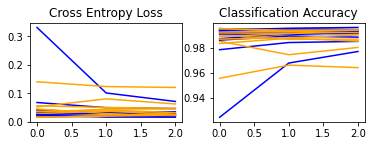

Accuracy: mean=98.730 std=0.890, n=10


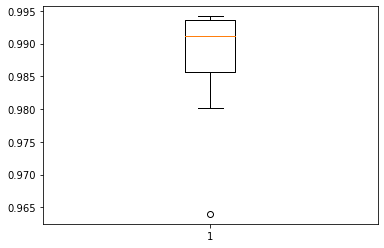

['Finetune on MNIST with LR=0.005 & epoch=3', 54.444, 99.567, 97.49]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.005)
scores, histories, model = evaluate_model(model, trainX, trainy,10,3,144)

model.save("finetuned_3")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on MNIST with LR=0.005 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Fine tune on the mix of perfect data and MNIST:

---



In [ ]:
trainmixX = np. concatenate((trainX, train_per_x), axis=0)
trainmixy = np. concatenate((trainy, train_per_y), axis=0)
print(trainmixX.shape)
print(trainmixy.shape)

(60360, 28, 28, 1)
(60360, 10)


Epoch 1/3
378/378 [==============================] - 4s 8ms/step - loss: 4.7776 - accuracy: 0.5496 - val_loss: 1.5323 - val_accuracy: 0.6968
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 1.0020 - accuracy: 0.7648 - val_loss: 0.6138 - val_accuracy: 0.8221
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.4234 - accuracy: 0.8698
> 86.978
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.3862 - accuracy: 0.8854 - val_loss: 0.3327 - val_accuracy: 0.9018
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.3149 - accuracy: 0.9064 - val_loss: 0.2761 - val_accuracy: 0.9183
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.2368 - accuracy: 0.9307
> 93.075
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.2291 - accuracy: 0.9320 - val_loss: 0.2212 - val_accuracy: 0.9334
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.2028

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


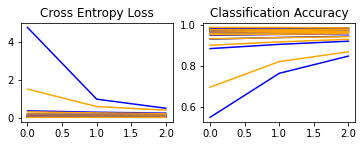

Accuracy: mean=95.603 std=3.320, n=10


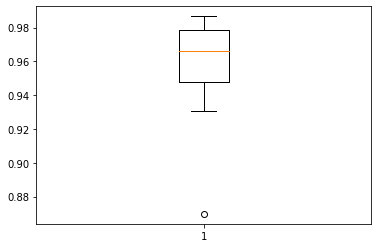

['Finetune on Mix data with LR=0.0001 & epoch=3', 98.889, 98.893, 97.45]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)

model.save("finetuned_4")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.0001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.8192 - accuracy: 0.8572 - val_loss: 0.1983 - val_accuracy: 0.9399
Epoch 2/3
378/378 [==============================] - 3s 7ms/step - loss: 0.1489 - accuracy: 0.9550 - val_loss: 0.1402 - val_accuracy: 0.9596
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.1169 - accuracy: 0.9652
> 96.521
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0796 - accuracy: 0.9762 - val_loss: 0.0672 - val_accuracy: 0.9803
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0608 - accuracy: 0.9816 - val_loss: 0.0593 - val_accuracy: 0.9826
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0562 - accuracy: 0.9823
> 98.227
Epoch 1/3
378/378 [==============================] - 4s 9ms/step - loss: 0.0392 - accuracy: 0.9882 - val_loss: 0.0392 - val_accuracy: 0.9884
Epoch 2/3
378/378 [==============================] - 5s 12ms/step - loss: 0.029

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


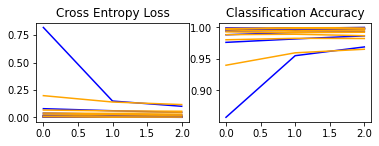

Accuracy: mean=99.102 std=1.007, n=10


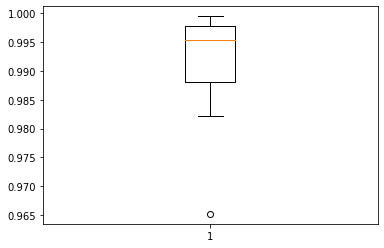

['Finetune on Mix data with LR=0.001 & epoch=3', 100.0, 99.912, 97.94]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)

model.save("finetuned_5")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
378/378 [==============================] - 4s 8ms/step - loss: 0.3423 - accuracy: 0.9225 - val_loss: 0.1493 - val_accuracy: 0.9551
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.1021 - accuracy: 0.9681 - val_loss: 0.1176 - val_accuracy: 0.9659
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.1088 - accuracy: 0.9687
> 96.869
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0649 - accuracy: 0.9790 - val_loss: 0.0586 - val_accuracy: 0.9801
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0535 - accuracy: 0.9825 - val_loss: 0.0568 - val_accuracy: 0.9816
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0583 - accuracy: 0.9814
> 98.144
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0423 - accuracy: 0.9866 - val_loss: 0.0640 - val_accuracy: 0.9811
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


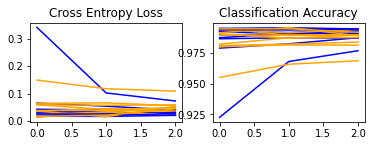

Accuracy: mean=98.661 std=0.691, n=10


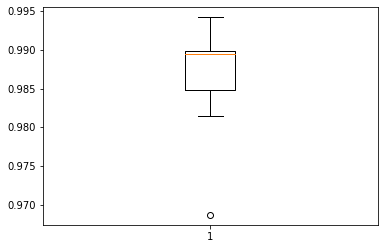

['Finetune on Mix data with LR=0.005 & epoch=3', 98.333, 99.287, 97.43]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.005)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)

model.save("finetuned_6")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.005 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.8866 - accuracy: 0.8478 - val_loss: 0.2090 - val_accuracy: 0.9377
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.1569 - accuracy: 0.9527 - val_loss: 0.1454 - val_accuracy: 0.9602
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.1222 - accuracy: 0.9631
> 96.306
Epoch 1/3
378/378 [==============================] - 3s 7ms/step - loss: 0.0844 - accuracy: 0.9745 - val_loss: 0.0693 - val_accuracy: 0.9781
Epoch 2/3
378/378 [==============================] - 3s 7ms/step - loss: 0.0643 - accuracy: 0.9804 - val_loss: 0.0620 - val_accuracy: 0.9811
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.9819
> 98.194
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0415 - accuracy: 0.9881 - val_loss: 0.0399 - val_accuracy: 0.9889
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0323

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


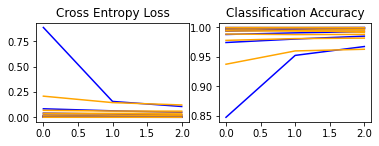

Accuracy: mean=99.087 std=1.066, n=10


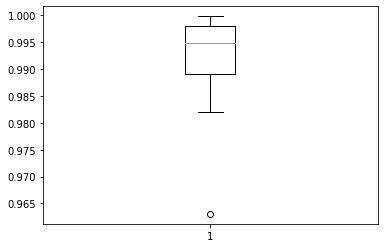

['Finetune on Mix data with LR=0.0009 & epoch=3', 100.0, 99.993, 98.02]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0009)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)

model.save("finetuned_7")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.0009 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
378/378 [==============================] - 4s 9ms/step - loss: 0.5221 - accuracy: 0.8966 - val_loss: 0.1609 - val_accuracy: 0.9525
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.1136 - accuracy: 0.9652 - val_loss: 0.1130 - val_accuracy: 0.9687
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.1026 - accuracy: 0.9690
> 96.902
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0595 - accuracy: 0.9817 - val_loss: 0.0444 - val_accuracy: 0.9862
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0436 - accuracy: 0.9864 - val_loss: 0.0487 - val_accuracy: 0.9838
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0598 - accuracy: 0.9813
> 98.128
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.0291 - val_accuracy: 0.9919
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0226

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


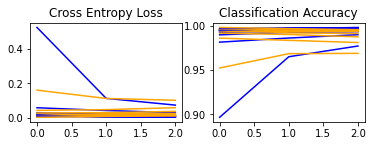

Accuracy: mean=98.999 std=0.825, n=10


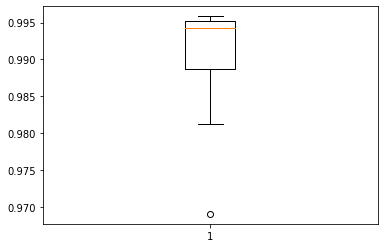

['Finetune on Mix data with LR=0.002 & epoch=3', 100.0, 99.792, 98.06]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.002)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)

model.save("finetuned_8")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.002 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
378/378 [==============================] - 4s 9ms/step - loss: 0.4165 - accuracy: 0.9111 - val_loss: 0.1526 - val_accuracy: 0.9561
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.1066 - accuracy: 0.9674 - val_loss: 0.1208 - val_accuracy: 0.9660
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.1004 - accuracy: 0.9710
> 97.101
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0586 - accuracy: 0.9815 - val_loss: 0.0497 - val_accuracy: 0.9829
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0450 - accuracy: 0.9856 - val_loss: 0.0634 - val_accuracy: 0.9785
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0574 - accuracy: 0.9824
> 98.244
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0345 - accuracy: 0.9882 - val_loss: 0.0391 - val_accuracy: 0.9872
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0253

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


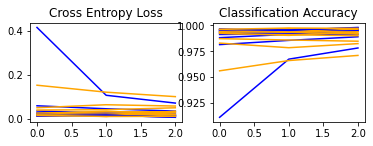

Accuracy: mean=98.931 std=0.754, n=10


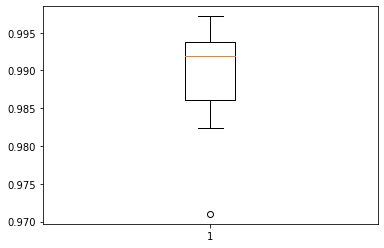

['Finetune on Mix data with LR=0.003 & epoch=3', 100.0, 99.853, 98.0]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.003)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)

model.save("finetuned_9")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on Mix data with LR=0.003 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

What if we trained the random initialized model on mix data:

---



Epoch 1/3
378/378 [==============================] - 4s 9ms/step - loss: 0.3139 - accuracy: 0.9112 - val_loss: 0.1698 - val_accuracy: 0.9498
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.1213 - accuracy: 0.9636 - val_loss: 0.1153 - val_accuracy: 0.9677
Epoch 3/3
189/189 [==============================] - 1s 3ms/step - loss: 0.1027 - accuracy: 0.9695
> 96.952
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0621 - accuracy: 0.9808 - val_loss: 0.0565 - val_accuracy: 0.9816
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0461 - accuracy: 0.9854 - val_loss: 0.0555 - val_accuracy: 0.9816
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9829
> 98.294
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.0399 - val_accuracy: 0.9887
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0217

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


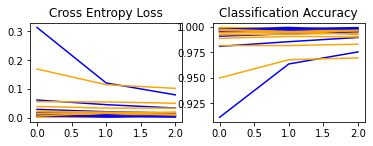

Accuracy: mean=99.120 std=0.838, n=10


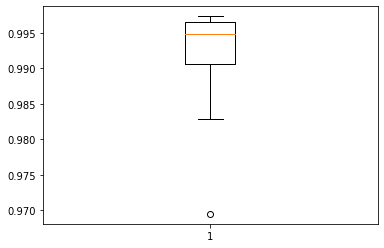

['Random init on Mix data with LR=0.001 & epoch=3', 100.0, 99.86, 97.93]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random init on Mix data with LR=0.001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
378/378 [==============================] - 4s 9ms/step - loss: 0.2582 - accuracy: 0.9245 - val_loss: 0.1425 - val_accuracy: 0.9571
Epoch 2/3
378/378 [==============================] - 3s 9ms/step - loss: 0.1018 - accuracy: 0.9689 - val_loss: 0.1010 - val_accuracy: 0.9697
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.1010 - accuracy: 0.9689
> 96.885
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0553 - accuracy: 0.9828 - val_loss: 0.0508 - val_accuracy: 0.9826
Epoch 2/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0408 - accuracy: 0.9871 - val_loss: 0.0601 - val_accuracy: 0.9806
Epoch 3/3
189/189 [==============================] - 0s 2ms/step - loss: 0.0456 - accuracy: 0.9859
> 98.592
Epoch 1/3
378/378 [==============================] - 3s 8ms/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.0281 - val_accuracy: 0.9909
Epoch 2/3
378/378 [==============================] - 3s 7ms/step - loss: 0.0229

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


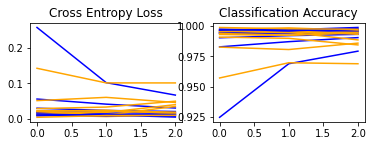

Accuracy: mean=98.999 std=0.825, n=10


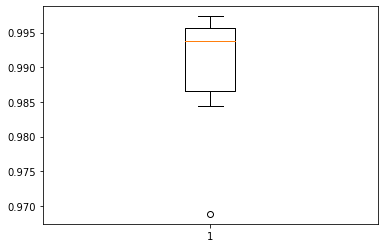

['Random init on Mix data with LR=0.002 & epoch=3', 100.0, 99.712, 98.02]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.002)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random init on Mix data with LR=0.002 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

What if the training set is not that big:

---



In [ ]:
train_l_X = trainX[:5000]
train_l_y = trainy[:5000]
trainmixX = np. concatenate((train_l_X, train_per_x), axis=0)
trainmixy = np. concatenate((train_l_y, train_per_y), axis=0)
print(trainmixX.shape)
print(trainmixy.shape)

(5360, 28, 28, 1)
(5360, 10)


Epoch 1/3
32/32 [==============================] - 1s 14ms/step - loss: 1.1051 - accuracy: 0.7240 - val_loss: 0.4638 - val_accuracy: 0.8660
Epoch 2/3
32/32 [==============================] - 0s 8ms/step - loss: 0.3438 - accuracy: 0.9049 - val_loss: 0.3541 - val_accuracy: 0.9000
Epoch 3/3
16/16 [==============================] - 0s 3ms/step - loss: 0.3408 - accuracy: 0.9020
> 90.200
Epoch 1/3
32/32 [==============================] - 0s 10ms/step - loss: 0.2067 - accuracy: 0.9422 - val_loss: 0.2082 - val_accuracy: 0.9520
Epoch 2/3
32/32 [==============================] - 0s 8ms/step - loss: 0.1530 - accuracy: 0.9593 - val_loss: 0.1983 - val_accuracy: 0.9500
Epoch 3/3
16/16 [==============================] - 0s 3ms/step - loss: 0.1855 - accuracy: 0.9580
> 95.800
Epoch 1/3
32/32 [==============================] - 0s 10ms/step - loss: 0.1096 - accuracy: 0.9716 - val_loss: 0.0978 - val_accuracy: 0.9700
Epoch 2/3
32/32 [==============================] - 0s 9ms/step - loss: 0.0907 - accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


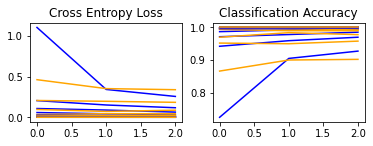

Accuracy: mean=98.160 std=2.940, n=10


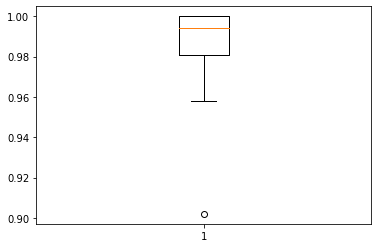

['Random initialized on tiny MNIST with LR=0.001 & epoch=3', 42.778, 94.523, 94.49]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, train_l_X, train_l_y,10,3,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on tiny MNIST with LR=0.001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
32/32 [==============================] - 1s 14ms/step - loss: 0.8296 - accuracy: 0.7689 - val_loss: 0.4750 - val_accuracy: 0.8660
Epoch 2/3
32/32 [==============================] - 0s 8ms/step - loss: 0.2894 - accuracy: 0.9140 - val_loss: 0.3337 - val_accuracy: 0.9020
Epoch 3/3
16/16 [==============================] - 0s 3ms/step - loss: 0.3044 - accuracy: 0.9100
> 91.000
Epoch 1/3
32/32 [==============================] - 1s 27ms/step - loss: 0.1494 - accuracy: 0.9584 - val_loss: 0.1441 - val_accuracy: 0.9620
Epoch 2/3
32/32 [==============================] - 0s 9ms/step - loss: 0.0943 - accuracy: 0.9782 - val_loss: 0.1444 - val_accuracy: 0.9660
Epoch 3/3
16/16 [==============================] - 0s 2ms/step - loss: 0.1425 - accuracy: 0.9700
> 97.000
Epoch 1/3
32/32 [==============================] - 0s 10ms/step - loss: 0.0647 - accuracy: 0.9827 - val_loss: 0.0525 - val_accuracy: 0.9840
Epoch 2/3
32/32 [==============================] - 0s 9ms/step - loss: 0.0406 - accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


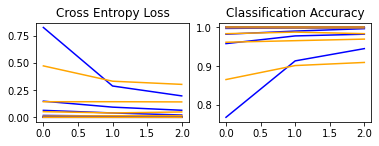

Accuracy: mean=98.620 std=2.712, n=10


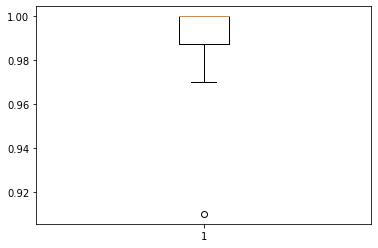

['Random initialized on tiny MNIST with LR=0.002 & epoch=3', 44.444, 94.903, 94.63]


In [ ]:
model = tf.keras.models.load_model("random_init")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.002)
scores, histories, model = evaluate_model(model, train_l_X, train_l_y,10,3,144)

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Random initialized on tiny MNIST with LR=0.002 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
32/32 [==============================] - 1s 15ms/step - loss: 5.4846 - accuracy: 0.5244 - val_loss: 1.7367 - val_accuracy: 0.6840
Epoch 2/3
32/32 [==============================] - 0s 8ms/step - loss: 1.1180 - accuracy: 0.7500 - val_loss: 0.7238 - val_accuracy: 0.8140
Epoch 3/3
16/16 [==============================] - 0s 2ms/step - loss: 0.5057 - accuracy: 0.8620
> 86.200
Epoch 1/3
32/32 [==============================] - 0s 9ms/step - loss: 0.3960 - accuracy: 0.8816 - val_loss: 0.4128 - val_accuracy: 0.8960
Epoch 2/3
32/32 [==============================] - 0s 9ms/step - loss: 0.3112 - accuracy: 0.9076 - val_loss: 0.3667 - val_accuracy: 0.9040
Epoch 3/3
16/16 [==============================] - 0s 2ms/step - loss: 0.3201 - accuracy: 0.9240
> 92.400
Epoch 1/3
32/32 [==============================] - 0s 9ms/step - loss: 0.2242 - accuracy: 0.9376 - val_loss: 0.1646 - val_accuracy: 0.9460
Epoch 2/3
32/32 [==============================] - 0s 8ms/step - loss: 0.1863 - accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


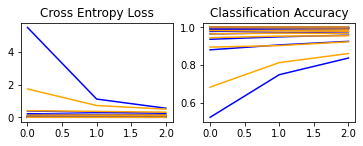

Accuracy: mean=96.660 std=4.162, n=10


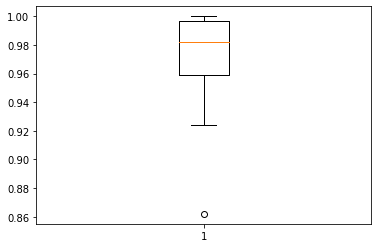

['Finetune on tiny MNIST with LR=0.001 & epoch=3', 84.444, 94.393, 94.29]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)
scores, histories, model = evaluate_model(model, train_l_X, train_l_y,10,3,144)

model.save("finetuned_10")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on tiny MNIST with LR=0.001 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
32/32 [==============================] - 1s 13ms/step - loss: 3.5183 - accuracy: 0.6209 - val_loss: 0.7002 - val_accuracy: 0.8100
Epoch 2/3
32/32 [==============================] - 0s 9ms/step - loss: 0.4909 - accuracy: 0.8540 - val_loss: 0.4228 - val_accuracy: 0.8680
Epoch 3/3
16/16 [==============================] - 0s 2ms/step - loss: 0.3476 - accuracy: 0.8960
> 89.600
Epoch 1/3
32/32 [==============================] - 0s 9ms/step - loss: 0.2229 - accuracy: 0.9362 - val_loss: 0.2270 - val_accuracy: 0.9480
Epoch 2/3
32/32 [==============================] - 0s 8ms/step - loss: 0.1622 - accuracy: 0.9564 - val_loss: 0.2047 - val_accuracy: 0.9460
Epoch 3/3
16/16 [==============================] - 0s 3ms/step - loss: 0.1896 - accuracy: 0.9540
> 95.400
Epoch 1/3
32/32 [==============================] - 0s 9ms/step - loss: 0.1056 - accuracy: 0.9729 - val_loss: 0.0737 - val_accuracy: 0.9780
Epoch 2/3
32/32 [==============================] - 0s 8ms/step - loss: 0.0805 - accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


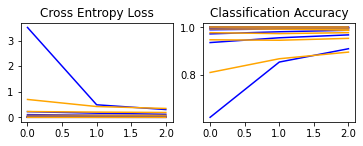

Accuracy: mean=98.060 std=3.138, n=10


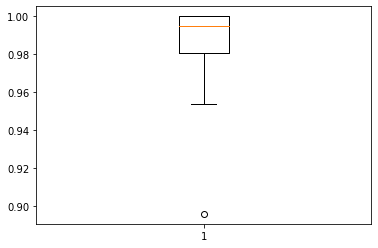

['Finetune on tiny MNIST with LR=0.002 & epoch=3', 77.222, 94.793, 94.68]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.002)
scores, histories, model = evaluate_model(model, train_l_X, train_l_y,10,3,144)

model.save("finetuned_10")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on tiny MNIST with LR=0.002 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Epoch 1/3
34/34 [==============================] - 1s 14ms/step - loss: 3.2269 - accuracy: 0.6459 - val_loss: 0.4460 - val_accuracy: 0.8489
Epoch 2/3
34/34 [==============================] - 0s 9ms/step - loss: 0.4665 - accuracy: 0.8648 - val_loss: 0.2723 - val_accuracy: 0.9123
Epoch 3/3
17/17 [==============================] - 0s 2ms/step - loss: 0.2133 - accuracy: 0.9403
> 94.030
Epoch 1/3
34/34 [==============================] - 0s 10ms/step - loss: 0.2084 - accuracy: 0.9430 - val_loss: 0.1840 - val_accuracy: 0.9459
Epoch 2/3
34/34 [==============================] - 0s 9ms/step - loss: 0.1515 - accuracy: 0.9600 - val_loss: 0.1718 - val_accuracy: 0.9440
Epoch 3/3
17/17 [==============================] - 0s 2ms/step - loss: 0.1580 - accuracy: 0.9515
> 95.149
Epoch 1/3
34/34 [==============================] - 0s 10ms/step - loss: 0.0912 - accuracy: 0.9760 - val_loss: 0.0999 - val_accuracy: 0.9739
Epoch 2/3
34/34 [==============================] - 0s 8ms/step - loss: 0.0656 - accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


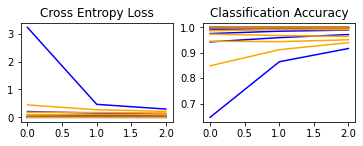

Accuracy: mean=98.433 std=2.195, n=10


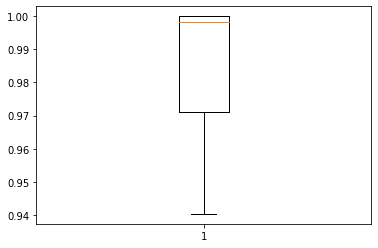

['Finetune on tiny Mix data with LR=0.002 & epoch=3', 100.0, 94.675, 94.66]


In [ ]:
model = tf.keras.models.load_model("trained_perfect_0.01")
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.002)
scores, histories, model = evaluate_model(model, trainmixX, trainmixy,10,3,144)

model.save("finetuned_11")

# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
desc = "Finetune on tiny Mix data with LR=0.002 & epoch=3"
results.append([desc,round(model.evaluate(train_per_x, train_per_y, verbose=0)[1]*100,3),round(model.evaluate(trainX, trainy, verbose=0)[1]*100,3),round(model.evaluate(testX, testy, verbose=0)[1]*100,3)])
print (results[len(results)-1])

Generating reults and download data:

---



In [ ]:
results

[['Random initialized with no training', 11.667, 10.393, 11.16],
 ['Random initialized on MNIST with LR=0.1 & epoch=3', 9.444, 18.385, 18.51],
 ['Random initialized on MNIST with LR=0.01 & epoch=3', 56.111, 99.287, 97.54],
 ['Random initialized on MNIST with LR=0.001 & epoch=3',
  55.556,
  99.928,
  98.04],
 ['Random initialized on MNIST with LR=0.002 & epoch=3', 57.222, 99.57, 97.83],
 ['Random initialized on MNIST with LR=0.0001 & epoch=3', 47.222, 99.38, 97.8],
 ['Random initialized on perfect data with LR=0.1 & epoch=8',
  56.667,
  21.275,
  21.85],
 ['Random initialized on perfect data with LR=0.05 & epoch=8',
  100.0,
  33.698,
  34.86],
 ['Random initialized on perfect data with LR=0.02 & epoch=8',
  100.0,
  37.223,
  38.29],
 ['Random initialized on perfect data with LR=0.01 & epoch=8',
  100.0,
  39.537,
  41.24],
 ['Random initialized on perfect data with LR=0.005 & epoch=8',
  100.0,
  37.337,
  38.7],
 ['Random initialized on perfect data with LR=0.001 & epoch=8',
  100.

In [ ]:
import pandas
df=pandas.DataFrame(results,list(range(1, len(results)+1)),["Description","Train perfect", "Train MNIST", "Test MNIST"])
df

,Description,Train perfect,Train MNIST,Test MNIST
1,Random initialized with no training,11.667,10.393,11.16
2,Random initialized on MNIST with LR=0.1 & epoch=3,9.444,18.385,18.51
3,Random initialized on MNIST with LR=0.01 & epo...,56.111,99.287,97.54
4,Random initialized on MNIST with LR=0.001 & ep...,55.556,99.928,98.04
5,Random initialized on MNIST with LR=0.002 & ep...,57.222,99.570,97.83
6,Random initialized on MNIST with LR=0.0001 & e...,47.222,99.380,97.80
7,Random initialized on perfect data with LR=0.1...,56.667,21.275,21.85
8,Random initialized on perfect data with LR=0.0...,100.000,33.698,34.86
9,Random initialized on perfect data with LR=0.0...,100.000,37.223,38.29
10,Random initialized on perfect data with LR=0.0...,100.000,39.537,41.24


In [ ]:
df.to_csv('results.csv', sep=',', encoding='utf-8')

In [ ]:
!zip -r /content/EXPANSE_two_step_training_colab.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/.metricsUUID (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.feature_flags_config.yaml (deflated 23%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.03.09/ (stored 0%)
  adding: content/.config/logs/2022.03.09/14.48.04.811374.log (deflated 55%)
  adding: content/.config/logs/2022.03.09/14.47.22.983659.log (deflated 54%)
  adding: content/.config/logs/2022.03.09/14.48.05.464073.log (deflated 54%)
  adding: content/.config/logs/2022.03.09/14.47.03.286667.log (deflated 91%)
  a

In [ ]:
files.download('results.csv') 
files.download('EXPANSE_two_step_training_colab.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>